In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import Adam
import matplotlib.pyplot as plt


In [7]:
# Define paths
train_dir = r'Data for task2\augmented_training_organized'
val_dir = r'Data for task2\validation_organized'
test_dir = r'Data for task2\testing_organized'

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Load pre-trained model
model = models.resnet18(pretrained=True)

# Freeze initial layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layer(s) or block(s)
for param in model.layer4.parameters():  # Unfreeze the last block
    param.requires_grad = True

# Modify the fully connected layer to match the number of classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


82


In [9]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [10]:
# Training loop
num_epochs = 10
train_accuracies, train_losses, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / len(val_dataset)
    val_accuracies.append(val_accuracy)

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

    # Save a copy of the model
    torch.save(model.state_dict(), f"task4_model_{epoch+1}.pth")


Epoch 1/10 - Train Loss: 2.1692 - Train Accuracy: 0.5546 - Val Loss: 1.0957 - Val Accuracy: 0.7869
Epoch 2/10 - Train Loss: 0.3865 - Train Accuracy: 0.9658 - Val Loss: 0.6596 - Val Accuracy: 0.8587
Epoch 3/10 - Train Loss: 0.0626 - Train Accuracy: 0.9992 - Val Loss: 0.5613 - Val Accuracy: 0.8778
Epoch 4/10 - Train Loss: 0.0212 - Train Accuracy: 1.0000 - Val Loss: 0.4961 - Val Accuracy: 0.8864
Epoch 5/10 - Train Loss: 0.0099 - Train Accuracy: 1.0000 - Val Loss: 0.4649 - Val Accuracy: 0.8925


KeyboardInterrupt: 

Test Loss: 0.5202, Test Accuracy: 0.8787


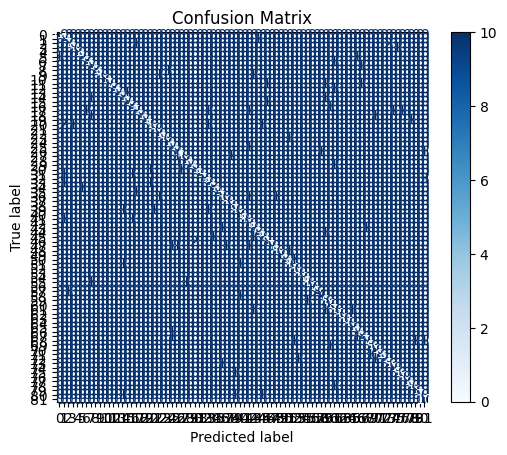

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.64      0.90      0.75        10
           2       0.88      0.70      0.78        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.89      0.80      0.84        10
           6       0.90      0.90      0.90        10
           7       0.75      0.90      0.82        10
           8       1.00      0.90      0.95        10
           9       1.00      0.80      0.89        10
          10       1.00      1.00      1.00        10
          11       1.00      0.70      0.82        10
          12       1.00      0.90      0.95        10
          13       1.00      0.90      0.95        10
          14       0.73      0.80      0.76        10
          15       0.90      0.90      0.90        10
          16       0.82      0.90      0.86        10
          17       0.71    

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test the model
model.eval()
correct = 0
all_preds = []
all_labels = []
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        
test_loss = test_loss / len(test_dataset)
test_accuracy = correct / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# print recall, precision, f1-score
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds))

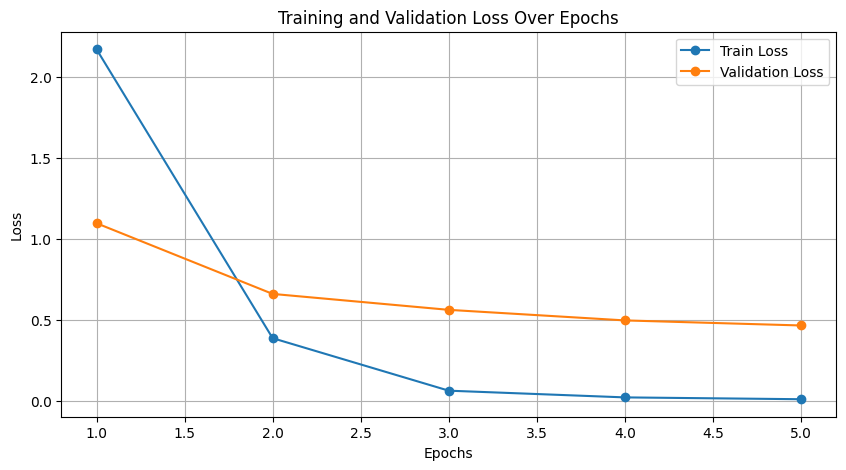

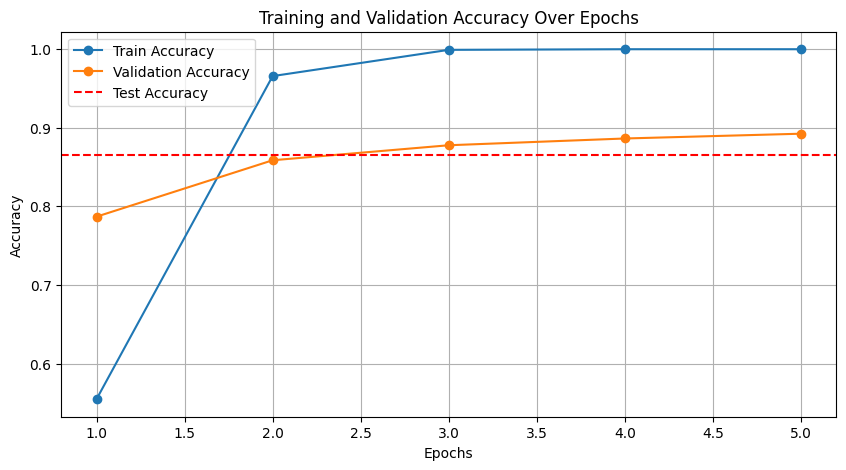

In [11]:
import matplotlib.pyplot as plt

# Data extracted from the training log
epochs = [1, 2, 3, 4, 5]
train_losses = [2.1692, 0.3865, 0.0626, 0.0212, 0.0099]
train_accuracies = [0.5546, 0.9658, 0.9992, 1.0000, 1.0000]
val_losses = [1.0957, 0.6596, 0.5613, 0.4961, 0.4649]
val_accuracies = [0.7869, 0.8587, 0.8778, 0.8864, 0.8925]
test_accuracy = 0.8652

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.axhline(test_accuracy, color="red", linestyle="--", label="Test Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
